In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils

In [4]:
include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/GraphPlottingBFS/dviWk.ji for GraphPlottingBFS [277fd268-772f-11e9-01e2-fbbcabd1ad4a]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/PGFPlotsX/ckKEQ.ji for PGFPlotsX [8314cec4-20b6-5062-9cdb-752b83310925]
└ @ Base loading.jl:1190


# Experiments:

Generate 4 environments for all experiments

In [ ]:
# env_graphs = []
# envs = []
# num_obstacle_cells = 64
# for (i,n) in enumerate([2,4,8])
#     obs_w = Int(sqrt(num_obstacle_cells)/n)
#     env = construct_regular_factory_world(;
#         n_obstacles_x=n,
#         n_obstacles_y=n,
#         obs_width = [obs_w;obs_w],
#         obs_offset = [obs_w;obs_w],
#         env_pad = [1;1],
#         env_offset = [1,1],
#         env_scale = 1 # this is essentially the robot diameter
#     )
#     filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml")
#     open(filename,"w") do io
#         TOML.print(io,env)
#     end
#     # graphics_filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".svg")
#     # visualize_env(env) |> SVG(graphics_filename)
#     push!(envs, env)
# end

In [ ]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(TaskGraphs.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename);
env_graph = factory_env;
dist_matrix = get_dist_matrix(env_graph);
p = visualize_env(factory_env)
# p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

# Record Video

In [ ]:
problem_id = 3
results_filename = joinpath(Pkg.devdir(),"TaskGraphs","dummy_results_dir","SparseAdjacencyMILP",string(:full_solver),string("results",problem_id,".toml"))
toml_dict = TOML.parsefile(results_filename);
robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
object_intervals = Vector{Vector{Int}}(toml_dict["object_intervals"]);
tf = maximum(map(p->length(p),robot_paths))
set_default_plot_size(18cm,18cm)
record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),
    t->render_paths(t,robot_paths,object_paths;object_intervals=object_intervals);tf=tf)

# Load results into dataframes

In [ ]:
# N_problems = 384
# problem_dir = PROBLEM_DIR
# results_dir = RESULTS_DIR
# # results_dir = joinpath(EXPERIMENT_DIR,"adjacency_solver/results")
# config_df = construct_config_dataframe(problem_dir,N_problems);

In [ ]:
# df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems)

# Display experimental results

In [5]:
set_default_plot_size(28cm,12cm)

In [ ]:
# p1 = robots_vs_task_vs_time_box_plot(df_dict[:full_solver]; 
#     title="Full Algorithm")
# # p1 |> PDF("FullAlgorithm.pdf", 20cm, 12cm)
# # p1

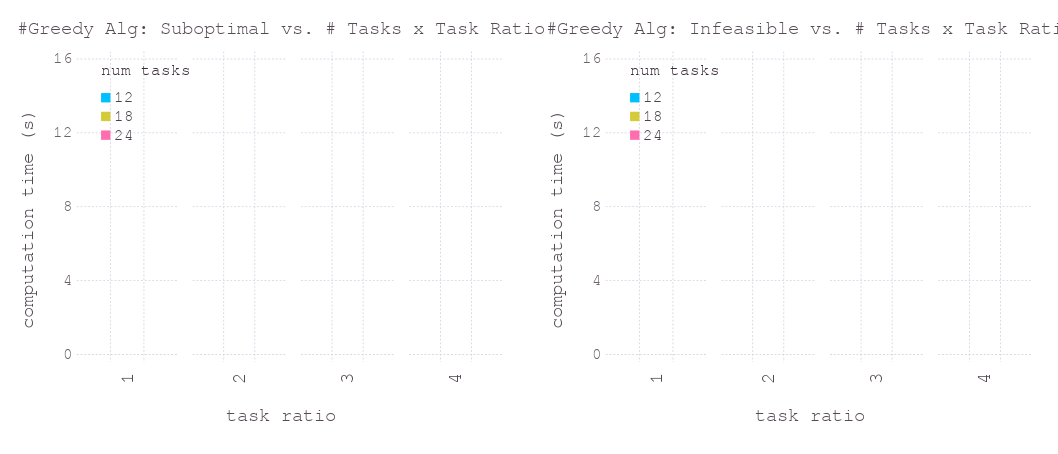

In [181]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
results_dir = joinpath(EXPERIMENT_DIR,"greedy_assignment/non_zero_collect_time/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);
hstack(
    plot_collab_counts(df_dict[:assignment_only];key=df_dict[:assignment_only].optimal,
        title="#Greedy Alg: Suboptimal vs. # Tasks x Task Ratio"),
    plot_collab_counts(df_dict[:assignment_only];key=df_dict[:assignment_only].feasible,
        title="#Greedy Alg: Infeasible vs. # Tasks x Task Ratio")
)

In [8]:
N_problems = 192
problem_dir = joinpath(PROBLEM_DIR,"collaborative_transport")
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport_dist_maps/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/collaborative_transport/results")
df_dict = construct_result_dataframes(problem_dir,results_dir,N_problems);
preprocess_collab_results!(df_dict);

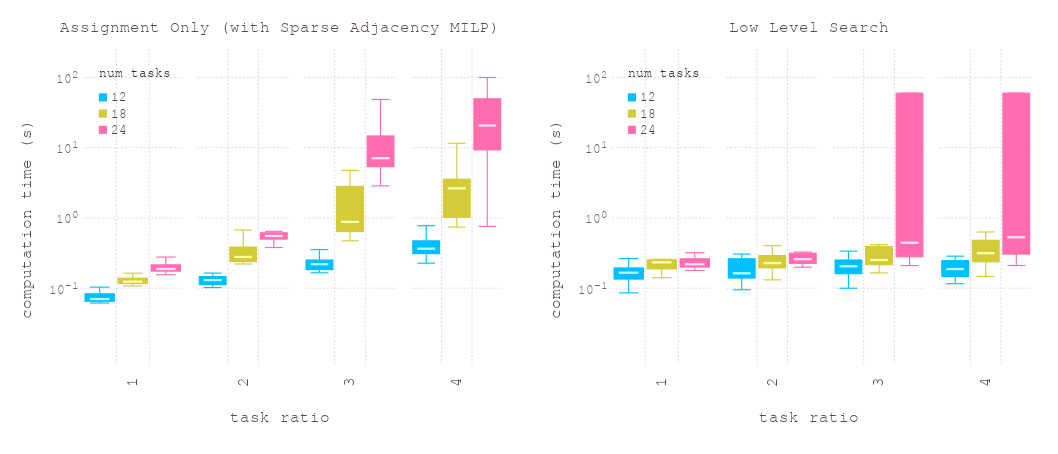

In [12]:
p1 = hstack(
    plot_collab_runtimes(
            df_dict[:assignment_only]; 
            title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt),
    plot_collab_runtimes(
            df_dict[:low_level_search_without_repair]; 
            title="Low Level Search",big_font=12pt,small_font=10pt),
#     plot_collab_runtimes(
#             df_dict[:full_solver]; 
#             title="Full Solver (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    
    )

In [ ]:
p1 |> SVG("CollabResults.svg", 28cm, 12cm)

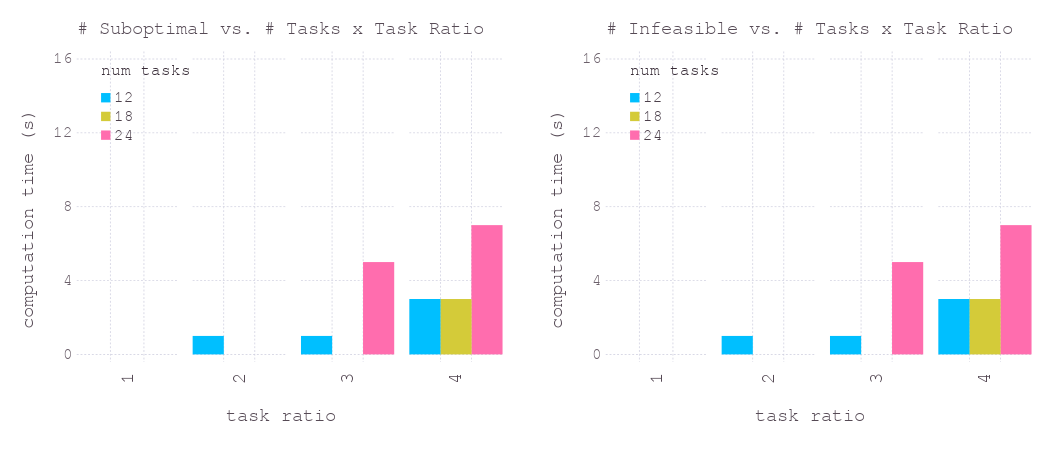

In [13]:
hstack(
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].optimal,
        title="# Suboptimal vs. # Tasks x Task Ratio"),
    plot_collab_counts(df_dict[:full_solver];key=df_dict[:full_solver].feasible,
        title="# Infeasible vs. # Tasks x Task Ratio")
)

In [ ]:
N_problems = 384
problem_dir = PROBLEM_DIR
# results_dir = RESULTS_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
        title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict1[:low_level_search_without_repair]; 
        title="low Level Search (with Assignment MILP)",big_font=12pt,small_font=10pt)
    )

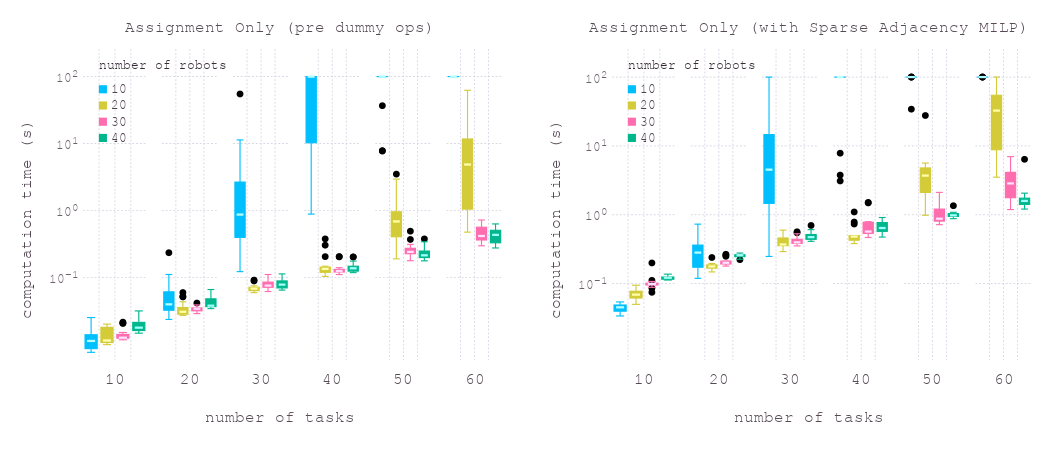

In [28]:
N_problems = 384
problem_dir = PROBLEM_DIR
results_dir = joinpath(EXPERIMENT_DIR,"assignment_solver/results")
# results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict1 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict1)
results_dir = joinpath(EXPERIMENT_DIR,"sparse_adjacency_solver/results")
df_dict2 = construct_result_dataframes(problem_dir,results_dir,N_problems)
preprocess_results!(df_dict2)
p1 = hstack(
    robots_vs_task_vs_time_box_plot(
        df_dict1[:assignment_only]; 
#         title="Assignment Only (with Assignment MILP)",big_font=12pt,small_font=10pt),
        title="Assignment Only (pre dummy ops)",big_font=12pt,small_font=10pt),
    robots_vs_task_vs_time_box_plot(
        df_dict2[:assignment_only]; 
        title="Assignment Only (with Sparse Adjacency MILP)",big_font=12pt,small_font=10pt)
    )

In [ ]:
p1 |> SVG("AssignmentHeadToHead.svg", 28cm, 12cm)

In [ ]:
# set_default_plot_size(20cm,9cm)
# p3 = robots_vs_task_vs_time_box_plot(
#     df_dict[:low_level_search_with_repair];title=nothing,yticks=[-1,0,1],ymin=-1.5,ymax=0.2)

In [14]:
using PGFPlotsX
latexengine!(PGFPlotsX.PDFLATEX)
using Printf

In [171]:
function get_box_plot_group_plot(df;
        obj=:time,
        outer_key=:M,
        inner_key=:N,
        outer_range=10:10:60,
        inner_range=10:10:40,
        xmin=0, 
        xmax=length(inner_range)+1,
        ymin=0.007,
        ymax=120,
        xtick=[10,20,30,40],
        xticklabels=[10,20,30,40],
        tickpos="left",
        ytick=[0.1,1,10,100],
        ylabel_shift="0pt",
        title="",
        title_shift=[3.3,2.55],
        inner_sym="n",
        outer_sym="m",
        xlabels=map(m->string(outer_sym," = ",m), outer_range),
        ylabels=map(n->string(inner_sym," = ",n), inner_range),
        draw_labels=true,
        ymode="log",
        width="3.25cm",
        height="6cm",)
    @pgf gp = GroupPlot({group_style = { 
                "group name"="myPlots",
                "group size"=string(length(outer_range)," by 1"),
                "xlabels at"="edge bottom",
                "xticklabels at"="edge bottom",
                "vertical sep"="0pt",
                "horizontal sep"="2pt"
            },
            boxplot,
            "boxplot/draw direction"="y",
            ymode="log",
            footnotesize,
            width=width,
            height="6cm",
            xmin=xmin, 
            xmax=xmax,
            ymin=ymin,
            ymax=ymax,
            xtick=xtick,
            xticklabels=xtick,
            tickpos="left",
            ytick=ytick,
            yticklabels=[],
            "ylabel shift"=ylabel_shift,
            "ytick align"="outside",
            "xtick align"="outside"});

    @pgf for (i,m) in enumerate(outer_range)
        if i == 1 && draw_labels
            push!(gp, 
                {xlabel=@sprintf("\$%s\$",xlabels[i]),
                ylabel="time (s)",
                yticklabels=ytick,
                "legend style"="{draw=none,fill=none,xshift=2pt}",
                "legend pos"="north west"},
                map(j->LegendEntry({},@sprintf("\$%s\$",ylabels[j]),false),1:length(inner_range))...,
                """
                \\addlegendimage{no markers,blue}
                \\addlegendimage{no markers,red}
                \\addlegendimage{no markers,brown}
                \\addlegendimage{no markers,black}
                """,
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df[:,outer_key] .== m) .& (df[:,inner_key] .== n),obj]])),inner_range)...)
        else
            push!(gp, {
                    xlabel=@sprintf("\$%s\$",xlabels[i]),
                    ymajorticks="false",
                    yminorticks="false"
                },
                map(n->PGFPlotsX.PlotInc({boxplot},Table(
                            {"y index"=0},
                            [:data=>df[(df[:,outer_key] .== m) .& (df[:,inner_key] .== n),obj]])),inner_range)...)
        end
    end;
    gp
end
function get_runtime_box_plot(df;
        title="",
        title_shift=[3.3,2.55],
        scale=0.7,
        kwargs...)
    gp = get_box_plot_group_plot(df;kwargs...)
    if title != ""
        tikzpic = @pgf TikzPicture({scale=scale},
            """
            \\centering
            """,
            gp,
            @sprintf("""
            \\node (title) at (\$(myPlots c1r1.center)!0.5!(myPlots c2r1.center)+(%2.2fcm,%2.2fcm)\$) {\\textbf{%s}};
            """,title_shift...,title)
        )
    else
        tikzpic = @pgf TikzPicture({scale=scale},
            """
            \\centering
            """,
            gp
        )
    end
    return tikzpic
end

# print_tex(gp)

get_runtime_box_plot (generic function with 1 method)

In [178]:
mode_list = [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
tmin = minimum(map(MODE->minimum(df_dict1[MODE].time),mode_list))
base_dir = joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/results")
for (filename, title, draw_labels,t_lo) in [
        (:assignment_only,"",true,tmin),
        (:low_level_search_without_repair,"",false,tmin),
        (:full_solver,"",true,0.5)
        ]

    open(joinpath(base_dir,string(filename,".tex")),"w") do io
        gp = get_runtime_box_plot(
            df_dict[filename];
            ymin=t_lo,
            title=title,
            obj=:time,
            outer_key=:TaskRatio,
            inner_key=:M,
            outer_range=1:1:4,
            inner_range=12:6:24,
            inner_sym="m",
            outer_sym="ratio",
            xtick=[12,18,24],
            title_shift=[1.8,2.55],
            draw_labels=draw_labels
        )
        print_tex(io, gp)
    end
end

In [ ]:
# titles = Dict(
#     :full_solver => "Runtime of Full \\PCTAPF{} Solver",
#     :assignment_only => "Runtime of Task Assignment MILP Solver",
#     :low_level_search_with_repair => "Runtime of \\LevelThreeLong{}",
#     :low_level_search_without_repair => "Runtime of \\LevelThreeLong{}",
# )
titles = Dict(
    :full_solver => "Experimental Results (Runtime)",
    :assignment_only => "",
    :low_level_search_with_repair => "",
    :low_level_search_without_repair => "",
)
for MODE in [:full_solver,:assignment_only,:low_level_search_without_repair,:low_level_search_with_repair]
    gp = get_runtime_box_plot(df_dict[MODE];ymin=tmin,title=titles[MODE])
#     open(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics",string(MODE,".tex")),"w") do io
    open(string(MODE,".tex"),"w") do io
        print_tex(io, gp)
    end
end